# Heart disease UCI dataset
[the dataset](https://www.kaggle.com/ronitf/heart-disease-uci)
[guide to dataset variables](https://www.kaggle.com/onatto/predicting-heart-disease-a-detailed-guide)

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pyro
import numpy as np
import pylab as pl
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO, Predictive

sns.set_theme()

from scripts import *
from models import *

pd.options.mode.chained_assignment = None  #hide pandas warnings

## Data exploration

In [5]:
# Import the dataset
data = pd.read_csv("../Datasets/hearth disease UCI/heart.csv", sep=",")


In [6]:
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [7]:
# rename columns
data.columns = ['age', 'sex', 'chest_pain', 'rest_blood_pressure', 'cholesterol', 'fast_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exercise_angina', 'st_depression', 'st_slope', 'major_vessels', 'thalassemia', 'target']

In [8]:
# look for null values
data.isnull().sum()

age                    0
sex                    0
chest_pain             0
rest_blood_pressure    0
cholesterol            0
fast_blood_sugar       0
rest_ecg               0
max_heart_rate         0
exercise_angina        0
st_depression          0
st_slope               0
major_vessels          0
thalassemia            0
target                 0
dtype: int64

In [9]:
data.dtypes

age                      int64
sex                      int64
chest_pain               int64
rest_blood_pressure      int64
cholesterol              int64
fast_blood_sugar         int64
rest_ecg                 int64
max_heart_rate           int64
exercise_angina          int64
st_depression          float64
st_slope                 int64
major_vessels            int64
thalassemia              int64
target                   int64
dtype: object

In [10]:
# modify types and labels for easy reading

data['sex'][data['sex'] == 0] = 'female'
data['sex'][data['sex'] == 1] = 'male'
data['sex'] = data['sex'].astype('object')

data['chest_pain'][data['chest_pain'] == 0] = 'typical angina'
data['chest_pain'][data['chest_pain'] == 1] = 'atypical angina'
data['chest_pain'][data['chest_pain'] == 2] = 'non-anginal pain'
data['chest_pain'][data['chest_pain'] == 3] = 'asymptomatic'
data['chest_pain'] = data['chest_pain'].astype('object')

data['fast_blood_sugar'][data['fast_blood_sugar'] == 0] = '≤ 120mg/ml'
data['fast_blood_sugar'][data['fast_blood_sugar'] == 1] = '> 120mg/ml'
data['fast_blood_sugar'] = data['fast_blood_sugar'].astype('object')

data['rest_ecg'][data['rest_ecg'] == 0] = 'normal'
data['rest_ecg'][data['rest_ecg'] == 1] = 'ST-T wave abnormality'
data['rest_ecg'][data['rest_ecg'] == 2] = ' left ventricular hypertrophy'
data['rest_ecg'] = data['rest_ecg'].astype('object')

data['exercise_angina'][data['exercise_angina'] == 0] = 'no'
data['exercise_angina'][data['exercise_angina'] == 1] = 'yes'
data['exercise_angina'] = data['exercise_angina'].astype('object')

data['st_slope'][data['st_slope'] == 0] = 'up'
data['st_slope'][data['st_slope'] == 1] = 'flat'
data['st_slope'][data['st_slope'] == 2] = 'down'
data['st_slope'] = data['st_slope'].astype('object')

data['thalassemia'][data['thalassemia'] == 0] = 'normal'
data['thalassemia'][data['thalassemia'] == 1] = 'fixed defect'
data['thalassemia'][data['thalassemia'] == 2] = 'reversable defect'
data['thalassemia'] = data['thalassemia'].astype('object')
# there is also a 3 but I don't know what it meanssss


In [11]:
data.describe()

,age,rest_blood_pressure,cholesterol,max_heart_rate,st_depression,major_vessels,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373,0.544554
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606,0.498835
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000


In [12]:
data.head(10)

,age,sex,chest_pain,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,st_slope,major_vessels,thalassemia,target
0,63,male,asymptomatic,145,233,> 120mg/ml,normal,150,no,2.3,up,0,fixed defect,1
1,37,male,non-anginal pain,130,250,≤ 120mg/ml,ST-T wave abnormality,187,no,3.5,up,0,reversable defect,1
2,41,female,atypical angina,130,204,≤ 120mg/ml,normal,172,no,1.4,down,0,reversable defect,1
3,56,male,atypical angina,120,236,≤ 120mg/ml,ST-T wave abnormality,178,no,0.8,down,0,reversable defect,1
4,57,female,typical angina,120,354,≤ 120mg/ml,ST-T wave abnormality,163,yes,0.6,down,0,reversable defect,1
5,57,male,typical angina,140,192,≤ 120mg/ml,ST-T wave abnormality,148,no,0.4,flat,0,fixed defect,1
6,56,female,atypical angina,140,294,≤ 120mg/ml,normal,153,no,1.3,flat,0,reversable defect,1
7,44,male,atypical angina,120,263,≤ 120mg/ml,ST-T wave abnormality,173,no,0.0,down,0,3,1
8,52,male,non-anginal pain,172,199,> 120mg/ml,ST-T wave abnormality,162,no,0.5,down,0,3,1
9,57,male,non-anginal pain,150,168,≤ 120mg/ml,ST-T wave abnormality,174,no,1.6,down,0,reversable defect,1


In [13]:
data.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [14]:
countNoD = len(data[data.target == 0])
countYesD = len(data[data.target == 1])
print("Percentage of patients without heart disease: {:.2f}%".format((countNoD / (len(data.target))*100)))
print("Percentage of patients with heart disease: {:.2f}%".format((countYesD / (len(data.target))*100)))

Percentage of patients without heart disease: 45.54%
Percentage of patients with heart disease: 54.46%


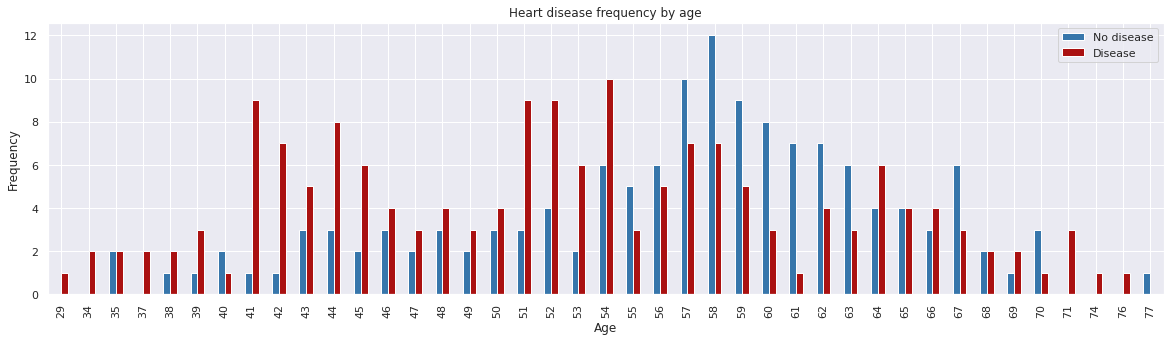

In [15]:
# target by age

pd.crosstab(data.age,data.target).plot(kind="bar",figsize=(20,5), color=['#3776ab','#AA1111' ])
plt.title('Heart disease frequency by age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(["No disease", "Disease"])
plt.show()

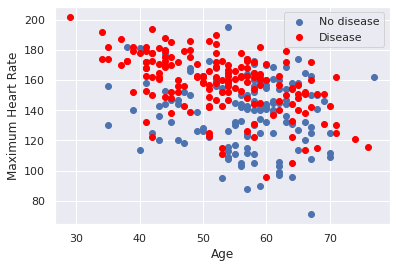

In [16]:
# target by max heart rate

plt.scatter(x=data.age[data.target==0], y=data.max_heart_rate[(data.target==0)])
plt.scatter(x=data.age[data.target==1], y=data.max_heart_rate[(data.target==1)], c="red")
plt.legend(["No disease", "Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

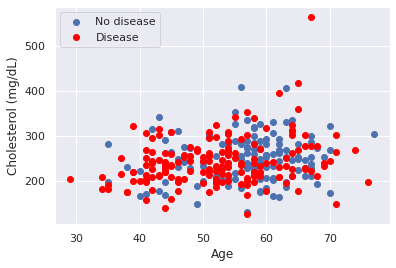

In [17]:
# target vs cholesterol

plt.scatter(x=data.age[data.target==0], y=data.cholesterol[(data.target==0)])
plt.scatter(x=data.age[data.target==1], y=data.cholesterol[(data.target==1)], c="red")
plt.legend(["No disease", "Disease"])
plt.xlabel("Age")
plt.ylabel("Cholesterol (mg/dL)")
plt.show()

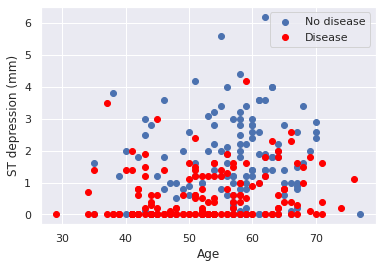

In [18]:
# target vs ST depression

plt.scatter(x=data.age[data.target==0], y=data.st_depression[(data.target==0)])
plt.scatter(x=data.age[data.target==1], y=data.st_depression[(data.target==1)], c="red")
plt.legend(["No disease", "Disease"])
plt.xlabel("Age")
plt.ylabel("ST depression (mm)")
plt.show()

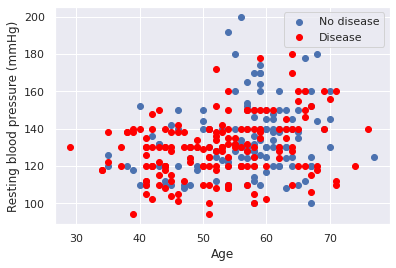

In [19]:
# target vs resting blood pressure

plt.scatter(x=data.age[data.target==0], y=data.rest_blood_pressure[(data.target==0)])
plt.scatter(x=data.age[data.target==1], y=data.rest_blood_pressure[(data.target==1)], c="red")
plt.legend(["No disease", "Disease"])
plt.xlabel("Age")
plt.ylabel("Resting blood pressure (mmHg)")
plt.show()

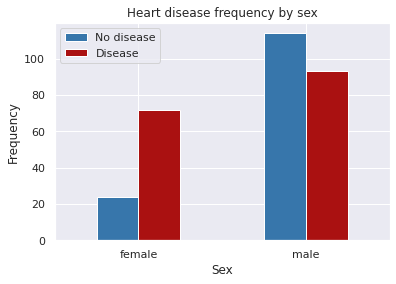

In [20]:
# target by sex

pd.crosstab(data.sex,data.target).plot(kind="bar",color=['#3776ab','#AA1111'])
plt.title('Heart disease frequency by sex')
plt.xlabel('Sex')
plt.xticks(rotation=0)
plt.legend(["No disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

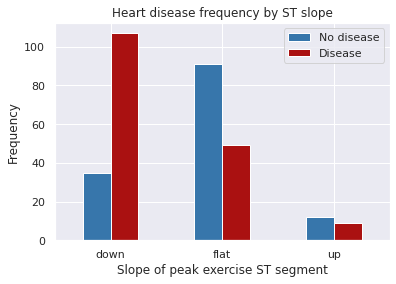

In [21]:
# target vs ST slope

pd.crosstab(data.st_slope, data.target).plot(kind="bar",color=['#3776ab','#AA1111'])
plt.title('Heart disease frequency by ST slope')
plt.xlabel('Slope of peak exercise ST segment')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.legend(["No disease", "Disease"])
plt.show()

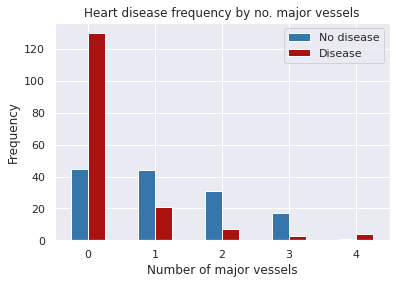

In [22]:
# target vs major vessels
# the more are coloured the more probability of heart disease -- to check

pd.crosstab(data.major_vessels , data.target).plot(kind="bar",color=['#3776ab','#AA1111'])
plt.title('Heart disease frequency by no. major vessels')
plt.xlabel('Number of major vessels')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.legend(["No disease", "Disease"])
plt.show()

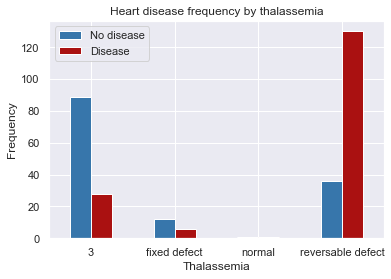

In [178]:
# target vs thalassemia

pd.crosstab(data.thalassemia, data.target).plot(kind="bar",color=['#3776ab','#AA1111'])
plt.title('Heart disease frequency by thalassemia')
plt.xlabel('Thalassemia')
plt.xticks(rotation = 0)
plt.ylabel('Frequency')
plt.legend(["No disease", "Disease"])
plt.show()

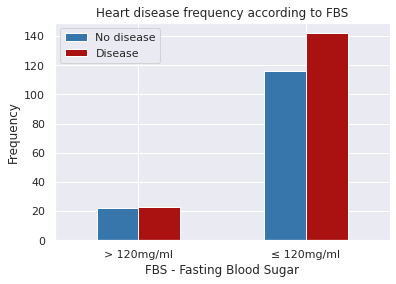

In [28]:
# target vs fasting blood sugar
# come inverto le colonne?
pd.crosstab(data.fast_blood_sugar,data.target).plot(kind="bar",color=['#3776ab','#AA1111'])
plt.title('Heart disease frequency according to FBS')
plt.xlabel('FBS - Fasting Blood Sugar')
plt.xticks(rotation = 0)
plt.legend(["No disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

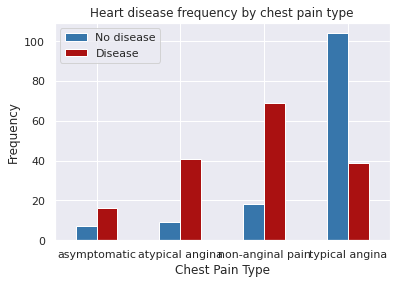

In [30]:
# target vs type of chest pain

pd.crosstab(data.chest_pain ,data.target).plot(kind="bar",color=['#3776ab','#AA1111'])
plt.title('Heart disease frequency by chest pain type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.legend(["No disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

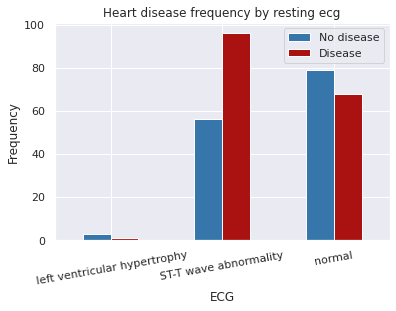

In [31]:
# target vs rest ecg

pd.crosstab(data.rest_ecg ,data.target).plot(kind="bar",color=['#3776ab','#AA1111'])
plt.title('Heart disease frequency by resting ecg')
plt.xlabel('ECG')
plt.xticks(rotation = 10)
plt.legend(["No disease", "Disease"])
plt.ylabel('Frequency')
plt.show()

In [32]:
# For the categorical variables, we need to create dummy variables
# Drop first category of each, eg. rather than having 'male' and 'female', male' with values of 0 or 1 (1 male, and 0 female)

# useful?

data2 = pd.get_dummies(data, drop_first=True)

# reorder columns to have target as last and sex as second

data2 = data2[['age', 'sex_male', 'rest_blood_pressure', 'cholesterol', 'max_heart_rate', 'st_depression', 'major_vessels', 'chest_pain_atypical angina', 'chest_pain_non-anginal pain', 'chest_pain_typical angina', 'fast_blood_sugar_≤ 120mg/ml', 'rest_ecg_ST-T wave abnormality', 'rest_ecg_normal', 'exercise_angina_yes', 'st_slope_flat', 'st_slope_up', 'thalassemia_fixed defect', 'thalassemia_normal', 'thalassemia_reversable defect',  'target']]

data2.head(10)

,age,sex_male,rest_blood_pressure,cholesterol,max_heart_rate,st_depression,major_vessels,chest_pain_atypical angina,chest_pain_non-anginal pain,chest_pain_typical angina,fast_blood_sugar_≤ 120mg/ml,rest_ecg_ST-T wave abnormality,rest_ecg_normal,exercise_angina_yes,st_slope_flat,st_slope_up,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect,target
0,63,1,145,233,150,2.3,0,0,0,0,0,0,1,0,0,1,1,0,0,1
1,37,1,130,250,187,3.5,0,0,1,0,1,1,0,0,0,1,0,0,1,1
2,41,0,130,204,172,1.4,0,1,0,0,1,0,1,0,0,0,0,0,1,1
3,56,1,120,236,178,0.8,0,1,0,0,1,1,0,0,0,0,0,0,1,1
4,57,0,120,354,163,0.6,0,0,0,1,1,1,0,1,0,0,0,0,1,1
5,57,1,140,192,148,0.4,0,0,0,1,1,1,0,0,1,0,1,0,0,1
6,56,0,140,294,153,1.3,0,1,0,0,1,0,1,0,1,0,0,0,1,1
7,44,1,120,263,173,0.0,0,1,0,0,1,1,0,0,0,0,0,0,0,1
8,52,1,172,199,162,0.5,0,0,1,0,0,1,0,0,0,0,0,0,0,1
9,57,1,150,168,174,1.6,0,0,1,0,1,1,0,0,0,0,0,0,1,1


## Data analysis

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.naive_bayes import GaussianNB
import random

random.seed(28)

In [59]:
# re-read data to go back to numerical values
data = pd.read_csv("../Datasets/hearth disease UCI/heart.csv", sep=",")
data.columns = ['age', 'sex', 'chest_pain', 'rest_blood_pressure', 'cholesterol', 'fast_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exercise_angina', 'st_depression', 'st_slope', 'major_vessels', 'thalassemia', 'target']

# Split into X and y 
y = data.target.to_numpy()
X = data.drop(['target'], axis = 1)

# Normalize the data
X = normalize_dataframe(X).to_numpy()

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [60]:
data.head()

,age,sex,chest_pain,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,st_slope,major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [61]:
# logistic regression

model = LogisticRegression().fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))
acc = model.score(X_test,y_test)*100
print("Test Accuracy {:.2f}%".format(acc))

y_pred = model.predict(X_test)

print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# Coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75        25
           1       0.83      0.81      0.82        36

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61

Test Accuracy 78.69%
Mean squared error: 0.21
Coefficient of determination: 0.12


In [62]:
# Naive Bayes

nb = GaussianNB().fit(X_train, y_train)
print(classification_report(y_test, nb.predict(X_test)))
acc = nb.score(X_test,y_test)*100
print("Accuracy of Naive Bayes: {:.2f}%".format(acc))

y_pred_nb = nb.predict(X_test)

print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred_nb))
# Coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.53      0.64      0.58        25
           1       0.71      0.61      0.66        36

    accuracy                           0.62        61
   macro avg       0.62      0.63      0.62        61
weighted avg       0.64      0.62      0.63        61

Accuracy of Naive Bayes: 62.30%
Mean squared error: 0.38
Coefficient of determination: -0.56


In [73]:
# to tensor

X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)

<ipython-input-73-53189f9bcaa2>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
<ipython-input-73-53189f9bcaa2>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)


In [77]:
model_BLR = BayesianLogisticRegression().fit(X_train, y_train.float())

Sample: 100%|██████████| 600/600 [00:03, 163.26it/s, step size=5.11e-01, acc. prob=0.880]


In [78]:
model_BLR.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]     -0.21      0.27     -0.20     -0.64      0.23       nan      0.99
      w[1]     -0.83      0.29     -0.84     -1.27     -0.32       nan      1.00
      w[2]      1.01      0.24      1.03      0.57      1.31       nan      0.99
      w[3]     -0.30      0.20     -0.33     -0.60      0.03       nan      0.99
      w[4]     -0.01      0.24     -0.04     -0.37      0.38       nan      0.99
      w[5]     -0.02      0.24     -0.02     -0.33      0.40       nan      1.01
      w[6]      0.47      0.21      0.48      0.16      0.85       nan      0.99
      w[7]      0.33      0.29      0.31     -0.12      0.77       nan      0.99
      w[8]     -0.73      0.24     -0.72     -1.12     -0.31       nan      0.99
      w[9]     -0.99      0.27     -0.98     -1.36     -0.50       nan      1.00
     w[10]      0.33      0.25      0.32     -0.15      0.71       nan      0.99
     w[11]     -0.76      0

/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/infer/mcmc/util.py:416: UserWarning: Traceback (most recent call last):
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/infer/mcmc/util.py", line 414, in wrapped
    val = fn(sample, *args, **kwargs)
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/ops/stats.py", line 184, in effective_sample_size
    gamma_k_c = autocovariance(input, dim=0)  # N x C x sample_shape
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/ops/stats.py", line 135, in autocovariance
    return autocorrelation(input, dim) * input.var(dim, unbiased=False, keepdim=True)
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/ops/stats.py", line 112, in autocorrelation
    freqvec = torch.rfft(centered_signal, signal_ndim=1, onesided=False)
AttributeError: module 'torch' has no attribute 'rfft'

  warnings.warn(tb.format_exc())


In [79]:
model_BLR.score(X_test, y_test)

General Accuracy:  0.7868852459016393
Class 0: accuracy 0.76, support: 25
Class 1: accuracy 0.8055555555555556, support: 36


In [118]:
net = MLP(13, num_layers=2, hidden_size=128, device="cpu")

train_data = MatrixLoader(X_train, y_train.long())
test_data = MatrixLoader(X_test, y_test.long())
train_loader = DataLoader(train_data, batch_size=1024)
test_loader = DataLoader(test_data, batch_size=4096)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

net.fit(train_loader, optimizer, criterion, n_epochs=30)

Epoch: 30	 loss: 0.005302709992974997	 time: 0.024409055709838867


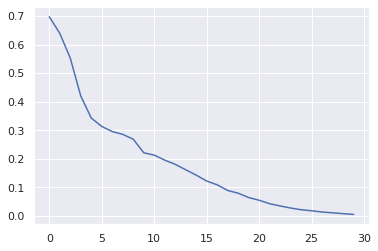

In [119]:
pl.plot(net.losses)

In [120]:
net.accuracy(test_loader)

tensor(0.7705)

In [180]:
net = MLP(13, num_layers=1, hidden_size=13, device="cpu")
bayesian_net = BayesianNetwork(net)
optimizer = pyro.optim.ClippedAdam({"lr":1e-2})
elbo = Trace_ELBO()

bayesian_net.fit(train_loader, optimizer, elbo, n_epochs=200)

Epoch: 200	 loss: 310.87644124031067	 time: 0.0054666996002197266


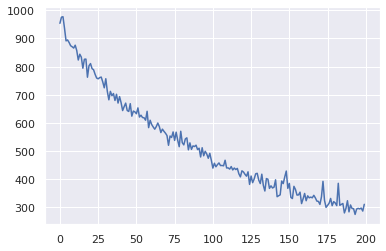

In [181]:
pl.plot(bayesian_net.losses)

In [190]:
bayesian_net.accuracy(test_loader, n_samples=100)

tensor(0.7869)